In [ ]:
import os
import pandas as pd
import shutil

# Define paths
dataset_path = 'anamelClassification.v1i.multiclass'
splits = ['train', 'val', 'test']

# Organize images into class subdirectories
for split in splits:
    csv_file = os.path.join(dataset_path, f"{split}/_classes.csv")
    split_folder = os.path.join(dataset_path, split)
    
    # Read the CSV file
    labels_df = pd.read_csv(csv_file)
    
    # Clean up column names (remove leading/trailing spaces)
    labels_df.columns = labels_df.columns.str.strip()
    
    # Class columns (excluding the filename column)
    class_columns = ['Anger and aggression', 'anxiety', 'happy', 'sad']
    
    for _, row in labels_df.iterrows():
        image_name = row['filename']  # Get the image filename
        
        # Determine the class label for the image
        class_label = None
        for class_name in class_columns:
            if row[class_name] == 1:  # Check if the column value is 1
                class_label = class_name
                break
        
        if class_label is None:
            print(f"Warning: No class label found for {image_name}")
            continue
        
        # Create class subdirectory if it doesn't exist
        class_dir = os.path.join(split_folder, class_label)
        os.makedirs(class_dir, exist_ok=True)
        
        # Move the image to the class subdirectory
        source_path = os.path.join(split_folder, image_name)
        dest_path = os.path.join(class_dir, image_name)
        
        if os.path.exists(source_path):
            shutil.move(source_path, dest_path)
        else:
            print(f"Warning: File {source_path} does not exist.")


In [ ]:
import tensorflow as tf
# Define image size and batch size
IMG_SIZE = (160, 160)  # Resize images to 160x160
BATCH_SIZE = 32

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 400 files belonging to 4 classes.
Found 50 files belonging to 4 classes.
Found 50 files belonging to 4 classes.


In [99]:
import tensorflow as tf
import os
import pathlib

# Define paths
dataset_path = 'anamelClassification.v1i.multiclass'  # Update this path
splits = ['train', 'valid', 'test']

# Set image size and batch size
IMG_SIZE = 160
BATCH_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1  # Normalize image
    return image

# Function to get the data from the directory
def load_data(split):
    # Define the path for each split (train, valid, test)
    split_path = os.path.join(dataset_path, split)
    image_paths = list(pathlib.Path(split_path).rglob('*.jpg'))  # Assuming images are .jpg, modify if needed
    image_paths = [str(path) for path in image_paths]
    
    # Extract labels (directories are the class labels)
    labels = [pathlib.Path(path).parent.name for path in image_paths]
    
    # Map labels to integers
    class_names = sorted(set(labels))  # List of unique class names
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    labels = [class_map[label] for label in labels]
    
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y))
    return dataset

# Load the datasets
train_dataset = load_data('train')
valid_dataset = load_data('valid')
test_dataset = load_data('test')

# Shuffle, batch and prefetch the data
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Check a sample batch shape
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)



(32, 160, 160, 3)


In [100]:
# Build the model using MobileNetV2 as the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')  # 4 classes

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [101]:


model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=valid_dataset)




Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - loss: 1.2533 - sparse_categorical_accuracy: 0.4681 - val_loss: 1.1321 - val_sparse_categorical_accuracy: 0.5600
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - loss: 0.9936 - sparse_categorical_accuracy: 0.6023 - val_loss: 1.0517 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 0.9813 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.9853 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.9119 - sparse_categorical_accuracy: 0.6013 - val_loss: 0.9260 - val_sparse_categorical_accuracy: 0.6400
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.8551 - sparse_categorical_accuracy: 0.6343 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.6600
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.8233 - val_sparse_categorical_accuracy: 0.7200
Epo

In [103]:
# Evaluate the model after initial training
initial_test_loss, initial_test_accuracy = model.evaluate(test_dataset, batch_size=32)
print(f"Initial Test Accuracy: {initial_test_accuracy:.4f}")
print(f"Initial Test Loss: {initial_test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.4498 - sparse_categorical_accuracy: 0.8175
Initial Test Accuracy: 0.8200
Initial Test Loss: 0.4731


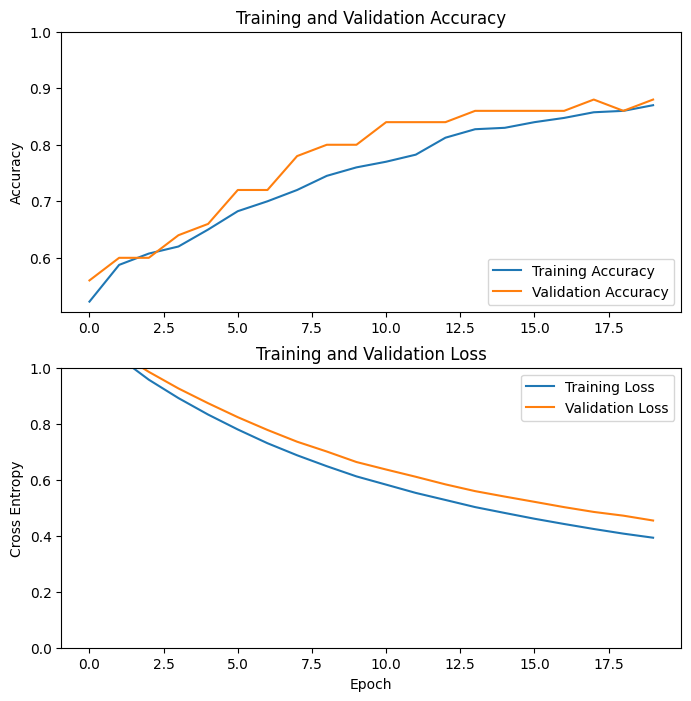

In [104]:
# Plot the training and validation accuracy and loss
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [105]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model for fine-tuning
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),  # Lower learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])




Number of layers in the base model:  154


In [106]:
# Fine-tune for a few more epochs
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Fit the model with the fine-tuning
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],  # Start from the last epoch of previous training
                         validation_data=valid_dataset)



Epoch 20/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 955ms/step - loss: 0.7517 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.4000 - val_sparse_categorical_accuracy: 0.8800
Epoch 21/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 655ms/step - loss: 0.4963 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.3705 - val_sparse_categorical_accuracy: 0.9000
Epoch 22/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 574ms/step - loss: 0.3905 - sparse_categorical_accuracy: 0.8426 - val_loss: 0.3506 - val_sparse_categorical_accuracy: 0.9000
Epoch 23/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 581ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.8846 - val_loss: 0.3321 - val_sparse_categorical_accuracy: 0.9000
Epoch 24/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 556ms/step - loss: 0.2441 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.3193 - val_sparse_categorical_accuracy: 0.9000
Epoch 25/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 569ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9340 - val_loss: 0.3070 - val_sparse_categorical_accuracy: 0.90

In [108]:
# Evaluate the model after fine-tuning
fine_tune_test_loss, fine_tune_test_accuracy = model.evaluate(test_dataset, batch_size=32)
print(f"Fine-Tuned Test Accuracy: {fine_tune_test_accuracy:.4f}")
print(f"Fine-Tuned Test Loss: {fine_tune_test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.3256 - sparse_categorical_accuracy: 0.8754
Fine-Tuned Test Accuracy: 0.8600
Fine-Tuned Test Loss: 0.3539


In [109]:
# Append the fine-tuned history to the original one
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


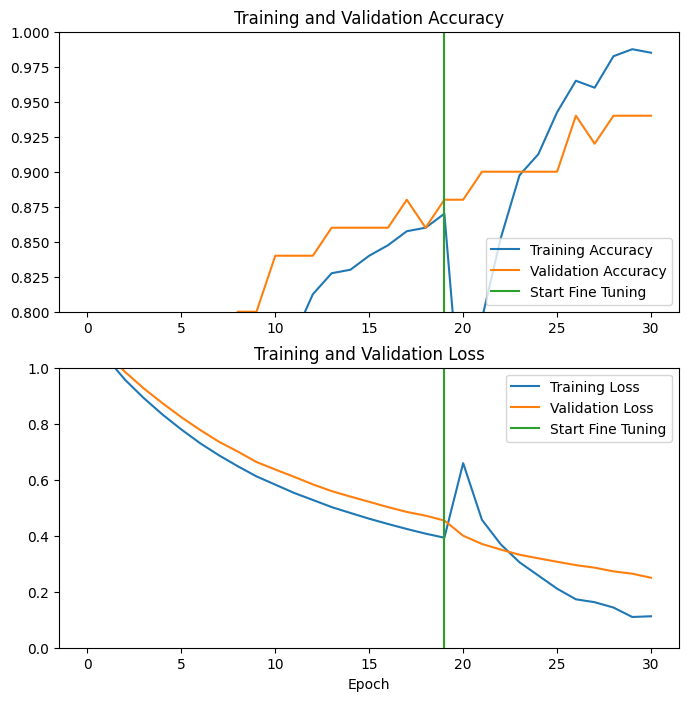

In [110]:
# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()



Found 50 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


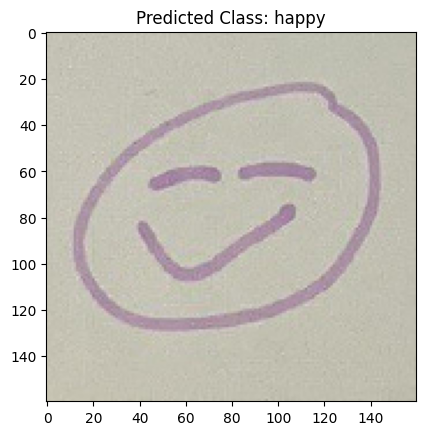

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Create the test generator (assuming 'test' folder is correct)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test = test_data.flow_from_directory('anamelClassification.v1i.multiclass/test', 
                                     target_size=(160, 160), 
                                     batch_size=32, 
                                     class_mode='categorical')

# Get one batch from the generator
image_batch, label_batch = next(test)

# Pick the first image in the batch
image = image_batch[0]
label = label_batch[0]

# Get the class names from the generator
class_names = list(test.class_indices.keys())

# Make a prediction
predicted_class_index = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the image with the predicted class name as title
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


In [125]:
# Save the model in TensorFlow's SavedModel format
model.save('MobileNetV2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


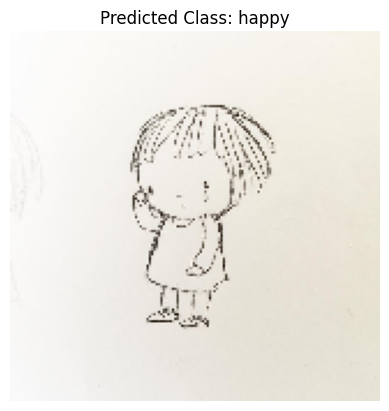

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = tf.keras.models.load_model('MobileNetV2.h5')

# Define the class names (ensure this matches your training setup)
class_names = ['Anger and aggression', 'anxiety', 'happy', 'sad']

# Path to the image you want to test
image_path = '2bf60eb6df4432927950c23cabdaf575.jpg'  # Replace with your image path


# Load the image with the same target size used during training
target_size = (160, 160)  # Update to the model's expected input size
image = load_img(image_path, target_size=target_size)

# Convert the image to a numpy array and preprocess it
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
image_array = image_array / 255.0  # Rescale the image (if necessary)

# Make a prediction
predicted_class_index = np.argmax(model.predict(image_array))
predicted_class_name = class_names[predicted_class_index]

# Display the image with the predicted class name as the title
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()